In [1]:
import os

download_name = "sms_spam_with_splits.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a02/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "sms_spam_with_splits.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))    

# SMS Classify

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [3]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    sms_spam_csv='sms_spam_with_splits.csv',
    
    # No Model hyper parameters
    
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,

)

### Vocabulary
👍 Create Vocabulary class with following methods:
* `__init__()` which initializes vocabulary by enabling or disabling unknown token `<UNK>` through `add_unk` argument (default=True)
* `add_token()` adding token to vocabulary
* `add_many()` adding multiple tokens into vocabulary
* `lookup_token()` returns index for given token
* `lookup_index()` return token for given index
* `__len__()` return size of vocabulary

In [4]:
class Vocabulary(object):
    
    def __init__(self, add_unk=True, unk_token="<UNK>"):
        self._token_to_idx = {}

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __len__(self):
        return len(self._token_to_idx)


vocab = Vocabulary()

vocab.add_token("john")
vocab.add_token("john")
vocab.add_token("ann")

vocab.lookup_token("john"), vocab.lookup_index(2)

    
vocab = Vocabulary(add_unk=True)

vocab.add_token("john")
vocab.add_token("john")
vocab.add_token("ann")

vocab.lookup_token("john"), vocab.lookup_index(2)

(1, 'ann')

### Vectorizer

👍 Create `SMSVectorizer` class with following methods:
* `__init__(self, sms_vocab, cls_vocab)` which will receive sms vocabulary (text of sms-es) and class vocabulary (ham or spam)
* `vectorize(self, sms)` returns one-hot representation of a given sms text.
* class method `from_dataframe(cls, sms_df, cutoff=25)` return SMSVectorizer instance by reading data from SMS dataframe and keep tokens whose frequency is larger then cutoff.

In [5]:
class SMSVectorizer(object):
    def __init__(self, sms_vocab, cls_vocab):
        self.sms_vocab = sms_vocab
        self.cls_vocab = cls_vocab

    def vectorize(self, sms):
        one_hot = np.zeros(len(self.sms_vocab), dtype=np.float32)
        
        for token in sms.split(" "):
            if token not in string.punctuation:
                one_hot[self.sms_vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, sms_df, cutoff=25):
        sms_vocab = Vocabulary(add_unk=True)
        cls_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for _cls in sorted(set(sms_df.cls)):
            cls_vocab.add_token(_cls)

        # Add top words if count > provided count
        word_counts = Counter()
        for sms in sms_df.sms:
            for word in sms.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                sms_vocab.add_token(word)

        return cls(sms_vocab, cls_vocab)

sms_vocab = Vocabulary()
sms_vocab.add_many("john has been there . but he is not john .".split())

cls_vocab = Vocabulary(add_unk=False)
cls_vocab.add_many(["spam", "ham"])

vectorizer = SMSVectorizer(sms_vocab, cls_vocab)
vectorizer.vectorize("but john has not been he .")        


array([0., 1., 1., 1., 0., 0., 1., 1., 0., 1.], dtype=float32)

### Read Dataset

👍 Create `SMSDataset` class which inherits `torch.utils.data.DataSet` and put following methods:
* `__init__(self, sms_df, vectorizer)` which will receive SMS dataframe and vectorizer and store them as attributes. SMS dataframe will be splitted into 3 dataframes according to split value (train, val or test) and those dataframes will be also stored as attributes.
* `set_split(self, split)` used for sellecting current split dataframe
* `__len__(self)` returns length of current split dataframe
* `__getitem__(self, index)` returns vectorized sms text and class for datapoint at given index
* `__get_num_batches(self, batch_size)` returns number of batches according to length of current split dataframe and batch size.
* class method `load_dataset_and_make_vectorizer(cls, sms_csv)` loads `sms_csv` file and makes vectorizer from **train** split. Then returns instance of `SMSDataset` with those two arguments.


In [6]:
class SMSDataset(Dataset):

    def __init__(self, sms_df, vectorizer):
        self.sms_df = sms_df
        self._vectorizer = vectorizer

        self.train_df = self.sms_df[self.sms_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.sms_df[self.sms_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.sms_df[self.sms_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': self.train_df,
                             'val': self.val_df,
                             'test': self.test_df}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, sms_csv):
        sms_df = pd.read_csv(sms_csv, sep="\t")
        train_sms_df = sms_df[sms_df.split=='train']
        return cls(sms_df, SMSVectorizer.from_dataframe(train_sms_df))
    
    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df = self._lookup_dict[split]

    def __len__(self):
        return len(self._target_df)

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        sms_vector = self._vectorizer.vectorize(row.sms)

        cls_index = self._vectorizer.cls_vocab.lookup_token(row.cls)
        return {'x_data': sms_vector,
                'y_target': cls_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size  


👍 Create function `generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu")` which will use `torch.utils.data.DataLoader` to yield batch.

In [7]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Load dataset and dataloader

In [8]:
dataset = SMSDataset.load_dataset_and_make_vectorizer(args.sms_spam_csv)
dataloader = DataLoader(dataset=dataset)

### Plot data

👍 Reduce dimensionality of data to 2D and plot spam and ham datapoints into separate plots.

In [9]:
from sklearn import decomposition
import matplotlib.pyplot as plt

  0%|          | 0/3899 [00:00<?, ?it/s]

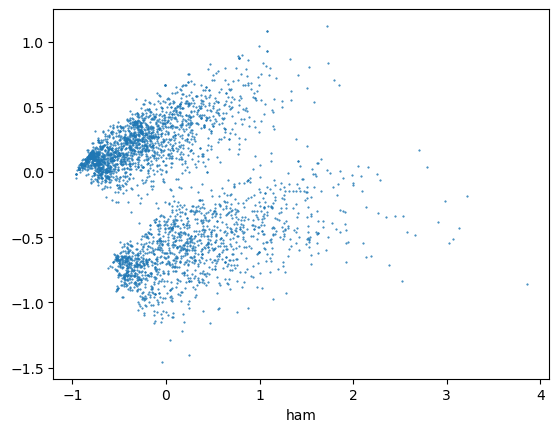

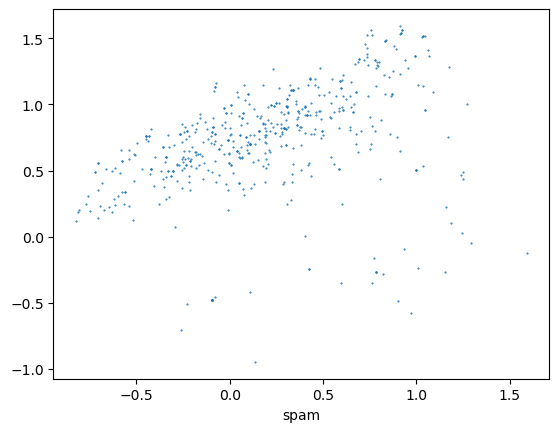

In [10]:
pca = decomposition.PCA(n_components=2)

x_data = []
y_target = []

i = 0
for item in tqdm(dataloader):
    x_data.append(item["x_data"].squeeze())
    y_target.append(item["y_target"].squeeze())

    
x_data = torch.stack(x_data)
y_target = torch.stack(y_target)

pca.fit(x_data)
X = pca.transform(x_data)


z = X[y_target==0]
plt.xlabel("ham")
plt.scatter(z[:,0], z[:,1], marker=".", s=1)
plt.show()

plt.xlabel("spam")
z = X[y_target==1]
plt.scatter(z[:,0], z[:,1], marker=".", s=1)
plt.show()

### Model Classifier

👍 Create `SMSClassifier` class as perceptron with varoable number of features. Methods are:
* `__init__(self, num_features)` initializes perceptron with `num_features` inputs
* `forward(self, x_in, apply_sigmoid=False)` for given input `x_in` makes forward step and eventually applies sigmoid on output.

In [11]:
class SMSClassifier(nn.Module):

    def __init__(self, num_features):
        super(SMSClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out


### Initialization

👍 Initialize by following steps:
* classifier
* args.device - setting to cuda if args.cuda is true and cuda is available, to cpu otherwise.
* switch classifier to args.device

In [12]:
dataset = SMSDataset.load_dataset_and_make_vectorizer(args.sms_spam_csv)
    
vectorizer = dataset.get_vectorizer()

classifier = SMSClassifier(num_features=len(vectorizer.sms_vocab))

args.device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(args.device)
classifier = classifier.to(args.device)

cpu


# Training

👍 Set:
* loss function to Binart Cross Entropy
* optimizer as Adam with specified learning rate by args.lr
* learning rate scheduler for reducing learning rate by 
    * factor 10 times less than actual args.lr
    * number of epochs with no improvement (patience) set to 1
    * minimum mode
    
For each epoch
* generate train batches and train (set classifier to train)
* generate val batches and validate (set classifier to eval)

In each batch print accuracy and loss.

In [13]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

for epoch_index in range(args.num_epochs):
    # TRAIN
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

    print(f"Train epoch: {epoch_index}/{args.num_epochs} loss: {running_loss:.3f} acc: {running_acc:.3f}")            

    # VAL
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        
    print(f"Valid epoch: {epoch_index+1}/{args.num_epochs} loss: {running_loss:.3f} acc: {running_acc:.3f}")                 
    scheduler.step(running_loss)
    

Train epoch: 0/100 loss: 0.662 acc: 67.812
Valid epoch: 1/100 loss: 0.615 acc: 88.021
Train epoch: 1/100 loss: 0.576 acc: 88.229
Valid epoch: 2/100 loss: 0.541 acc: 88.932
Train epoch: 2/100 loss: 0.514 acc: 88.177
Valid epoch: 3/100 loss: 0.490 acc: 88.021
Train epoch: 3/100 loss: 0.467 acc: 88.880
Valid epoch: 4/100 loss: 0.451 acc: 88.672
Train epoch: 4/100 loss: 0.430 acc: 89.609
Valid epoch: 5/100 loss: 0.417 acc: 89.323
Train epoch: 5/100 loss: 0.400 acc: 90.078
Valid epoch: 6/100 loss: 0.390 acc: 90.365
Train epoch: 6/100 loss: 0.373 acc: 90.938
Valid epoch: 7/100 loss: 0.363 acc: 91.406
Train epoch: 7/100 loss: 0.352 acc: 91.719
Valid epoch: 8/100 loss: 0.345 acc: 92.318
Train epoch: 8/100 loss: 0.333 acc: 92.448
Valid epoch: 9/100 loss: 0.324 acc: 93.359
Train epoch: 9/100 loss: 0.316 acc: 93.125
Valid epoch: 10/100 loss: 0.307 acc: 93.750
Train epoch: 10/100 loss: 0.300 acc: 93.698
Valid epoch: 11/100 loss: 0.302 acc: 93.620
Train epoch: 11/100 loss: 0.287 acc: 93.958
Valid e

# Test

👍 Generate test batches and for each batch print accuracy

In [14]:
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print(f"Test loss: {running_loss:.3f} acc: {running_acc:.3f}") 

Test loss: 0.112 acc: 98.568


# Interpretability

👍 Get classifier weights to determine 20 influental words for each class

In [15]:
fc1_weights = classifier.fc1.weight.cpu().detach()[0]
weights, indices = torch.sort(fc1_weights, dim=0, descending=True)

indices = indices.numpy().tolist()
print(x_data.shape, len(indices), vectorizer.sms_vocab)

# Top 20 words
print("Influential words in SPAM SMS:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.sms_vocab.lookup_index(indices[i]), end=" ")
    
print("\n====\n")

# Top 20 negative words
print("Influential words in HAM SMS:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.sms_vocab.lookup_index(indices[i]), end=" ")


torch.Size([3899, 359]) 359 <__main__.Vocabulary object at 0x7f88a1fb8af0>
Influential words in SPAM SMS:
--------------------------------------
uk p reply call txt free stop service mobile text claim www com customer won co win prize shows chat 
====

Influential words in HAM SMS:
--------------------------------------
ok gt lt yup right later <UNK> i then too home wat sorry she going come lol ya my da 